## Exploratory Data Analysis

We will be doing some EDA on information we've scraped from MyDramaList. This information includes 1. general information on romance kdramas we've decided to look at as well as the actors/actresses who've acted in these kdramas 2. reviews left by netizens on each of these kdramas. At the end, we will summarize the insights we've gained through this EDA.

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # We only need pyplot 
sb.set() # Set the default Seaborn style for graphics 

import matplotlib.pyplot as plt 
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
import wordcloud
from wordcloud import WordCloud

In C:\Users\jacin\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\jacin\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\jacin\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\jacin\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\jacin\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mpl

### 1. Basic analysis on general information

In [2]:
# Importing the dataset containing general information about the kdramas and actors
# Some minor data pre-processing after importing the dataset -- dropping columns we don't need for now and renaming roles for easy referral
data = pd.read_csv('cleaned_complete.csv').drop(['Unnamed: 0', 'Image', "CharName"], axis=1) 
data['Role'] = data['Role'].replace({'Main Role' : 'Main', 'Support Role' : 'Support', 'Guest Role' : 'Guest'})  

In [3]:
data

,Title,Role,ActorName,Gender
0,When Time Stopped,Main,Ahn Ji Hyun,Female
1,My Only Love Song,Support,Ahn Bo Hyun,Male
2,Itaewon Class,Support,Ahn Bo Hyun,Male
3,Her Private Life,Support,Ahn Bo Hyun,Male
4,Wednesday 3:30 PM,Main,Ahn Bo Hyun,Male
...,...,...,...,...
2133,My Girlfriend Is a Gumiho,Support,Yoon Yoo Sun,Female
2134,Shopping King Louie,Support,Yoon Yoo Sun,Female
2135,Can You Hear My Heart,Support,Youn Yuh Jung,Female
2136,Radio Romance,Main,Yura,Female


In [4]:
print("Data type : ", type(data))
print("Data dims : ", data.shape)
print(data.dtypes)

Data type :  <class 'pandas.core.frame.DataFrame'>
Data dims :  (2138, 4)
Title        object
Role         object
ActorName    object
Gender       object
dtype: object


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2138 entries, 0 to 2137
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Title      2138 non-null   object
 1   Role       2138 non-null   object
 2   ActorName  2138 non-null   object
 3   Gender     2138 non-null   object
dtypes: object(4)
memory usage: 66.9+ KB


In [6]:
# Statistical summary of all variables 
data.describe()

,Title,Role,ActorName,Gender
count,2138,2138,2138,2138
unique,357,3,1050,2
top,A Korean Odyssey,Main,Kim Ji Suk,Male
freq,6,1388,9,1205


Number of actors:  1205
Number of actresses:  933


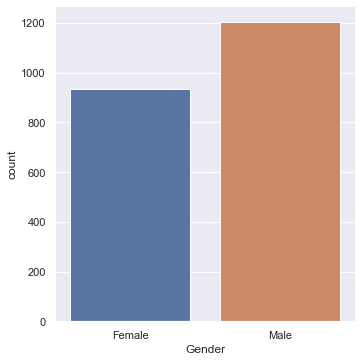

In [7]:
# Number of actors and actresses
print("Number of actors: ", data["Gender"].value_counts().Male)
print("Number of actresses: ", data["Gender"].value_counts().Female)
sb.catplot(x = "Gender", data = data, kind = "count")

Number of main roles:  1388
Number of support roles:  748
Number of guest roles:  2


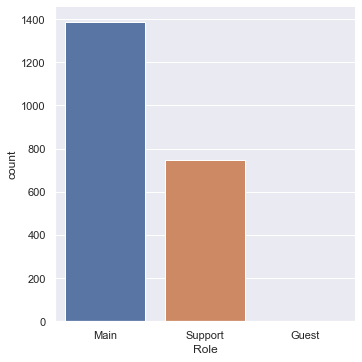

In [8]:
# Total number of actors and actresses in each kind of role
print("Number of main roles: ", data["Role"].value_counts().Main)
print("Number of support roles: ", data["Role"].value_counts().Support)
print("Number of guest roles: ", data["Role"].value_counts().Guest)
sb.catplot(x = "Role", data = data, kind = "count")

Number of actors in main roles:  785
Number of actresses in main roles:  603
Number of actors in support roles:  418
Number of actresses in support roles:  330
Number of actors in guest roles:  2
Number of actresses in guest roles:  0


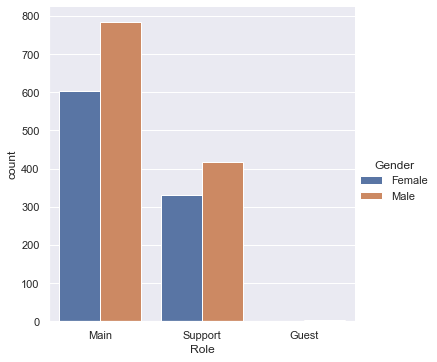

In [9]:
# Number of actors and actresses in each kind of role

# Actors and actresses in main roles
print("Number of actors in main roles: ", data[["Role", "Gender"]].value_counts().Main.Male)
print("Number of actresses in main roles: ", data[["Role", "Gender"]].value_counts().Main.Female)

# Actors and actresses in support roles
print("Number of actors in support roles: ", data[["Role", "Gender"]].value_counts().Support.Male)
print("Number of actresses in support roles: ", data[["Role", "Gender"]].value_counts().Support.Female)

# Actors and actresses in guest roles
print("Number of actors in guest roles: ", data[["Role", "Gender"]].value_counts().Guest.Male)
print("Number of actresses in guest roles: ", 0)

# Graphical visualisation 
sb.catplot(x = "Role", hue = "Gender", data = data, kind = "count")

In [10]:
# Unique actors/actresses in the dataset
print("Number of unique actors/actresses :", len(data["ActorName"].unique()))

# Number of times an actor/actress appeared in the dataset
print(data["ActorName"].value_counts(sort=True, ascending=False))

Number of unique actors/actresses : 1050
Kim Ji Suk        9
Sung Joon         9
Park Min Young    9
Ji Chang Wook     9
Yoon So Hee       8
                 ..
Kim Yo Han        1
Jei               1
Hong Ji Yoon      1
Park Sung Hoon    1
Uhm Jung Hwa      1
Name: ActorName, Length: 1050, dtype: int64


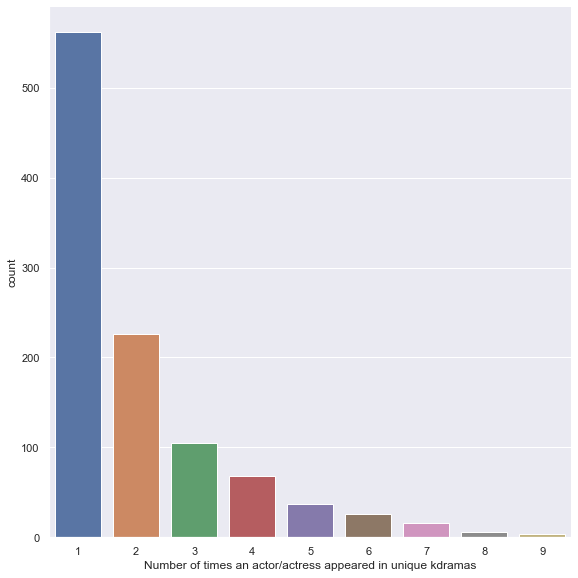

In [11]:
df = data["ActorName"]
df = df.value_counts().rename_axis('actor_names').reset_index(name='Number of times an actor/actress appeared in unique kdramas')
sb.catplot(x = 'Number of times an actor/actress appeared in unique kdramas', data = df, kind = 'count', height = 8)

### 2. Visualization of textual data (reviews) using a wordcloud 

In [12]:
# Importing the dataset containing all reviews for each kdrama. The reviews have been cleaned beforehand.
rev = pd.read_csv('clean.csv').drop(['Unnamed: 0'], axis=1)

In [13]:
# Create a list containing all the reviews
d_list = rev['review'].tolist()

In [14]:
# Convert list to string
d_str = ' '.join(d_list)

In [15]:
# Tokenize the words in the string
t = RegexpTokenizer(r'\w+')
tokens = t.tokenize(d_str)

In [16]:
# Lemmatize the words i.e. obtain the root form of words as a standardization
l = WordNetLemmatizer()
lemmas = [l.lemmatize(token.lower(), pos='v') for token in tokens]

In [17]:
# Remove stopwords i.e. words that do not contribute meaning to the sentence and can be safely ignored
cleaned_words = ' '.join([lemma for lemma in lemmas if lemma not in stopwords.words('english')])

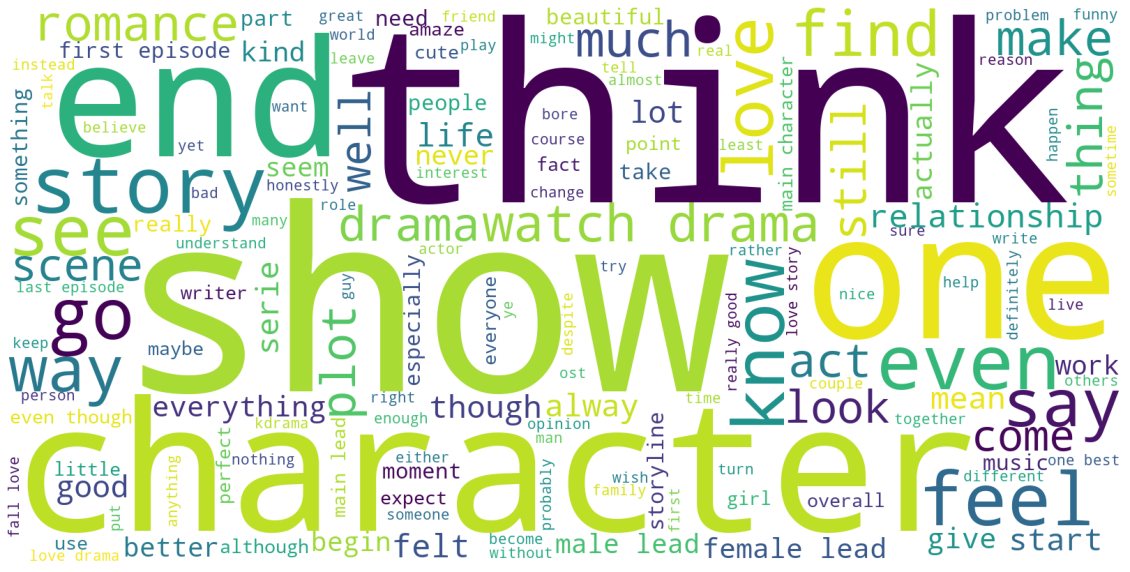

In [18]:
# Visualization of cleaned words using wordcloud
word_cloud = WordCloud(width=1600, height=800, max_words=150, background_color="white").generate(cleaned_words)
plt.figure(figsize=(20,20))
plt.imshow(word_cloud)
plt.savefig("test"+".png", bbox_inches='tight')
plt.axis("off")
plt.show()
plt.close()

## Insights

- Observation 1: Across each type of role eg main, support etc there is a higher number of actors than actresses. Overall, there are more actors than actresses in the dataset. Will this affect the number of pairings we will get, and will some actors be left without a pairing? 
> The pairings we are going to generate based on chemistry are not only restricted to pairings of the opposite gender, ie actor-actor and actress-actress pairings are possible too. We will be taking the best match with the highest possible chemistry either based on textual analysis or facial analysis. Hence, there may also be overlaps and some actors/actresses will be matched to the same actor/actress. This is especially the case for facial analysis, whereby a newcomer actor/actress will be matched to the same actor/actress as another actor/actress the newcomer looks similar to.
- Observation 2: There is a significantly high number of actors/actresses who have only acted in one kdrama in the dataset. These actors/actresses may possibly be newcomers who do not have enough experience and hence do not have enough past data for us to analyze. How are we going to match these newcomers based on the limited data we have about them?
> If we were to use textual analysis on reviews alone, we may not be able to get the best match for newcomers as some of them will only have one match; there are not enough options(potential matches) to make the best selection. To make up for this limitation, we will also be using facial analysis of the images of the actors/actresses we've scraped. The idea is that a newcomer who has high facial similarity to an experienced actor/actress will be matched to the actor/actress the experienced actor/actress is matched to. 
- Observation 3: The word cloud shows us the most commonly used words netizens use when writing reviews on the kdramas. A lot of common words do not seem to be related to chemistry at all, eg "show", "character", "story". What do we make of this?
> The word cloud can give us some insight on how netizens go about phrasing their views on the characters in the kdrama. It also allows us to think of alternative words netizens might use to describe chemistry between the actors/actresses, such as the words "romance" and "relationship" seen in the word cloud. Furthermore, netizens might not use the actor/actress's name when referring to them in the review, and might instead refer to them as "male lead", "female lead", "main couple" etc which we have to account for later when doing text sentiment analysis. 